In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# read the pickle file
with open('../tracker_stub/ball_detections8.pkl', 'rb') as f:
    ball_positions = pickle.load(f)
with open('../tracker_stub/court_keypoints.pkl', 'rb') as f:
    court_keypoints = pickle.load(f)
court_keypoints = court_keypoints.tolist()

In [3]:
ball_positions

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {1: [564.433349609375,
   186.29891967773438,
   573.91259765625,
   195.65396118164062]},
 {},
 {},
 {},
 {},
 {1: [708.1051635742188,
   445.96600341796875,
   726.1289672851562,
   463.54144287109375]},
 {1: [714.1600341796875,
   442.28472900390625,
   730.1702880859375,
   459.3287353515625]},
 {1: [722.3773193359375,
   442.6837463378906,
   734.7220458984375,
   454.9631042480469]},
 {1: [726.169189453125,
   439.18035888671875,
   740.331298828125,
   453.54156494140625]},
 {1: [731.9869384765625,
   438.5942077636719,
   746.0892333984375,
   452.8684387207031]},
 {1: [737.2264404296875,
   442.74713134765625,
   749.3992919921875,
   454.96783447265625]},
 {1: [735.6234741210938,
   444.5227355957031,
   756.8761596679688,
   464.9604187011719]},
 {1: [742.4515380859375,
   450.3148193359375,
   759.3770751953125,
   467.96575927734375]},
 {1: [745.7615966796875,
   457.4902038574219,
   761.714477539

In [4]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [46]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=10, min_periods=1, center=False).mean()

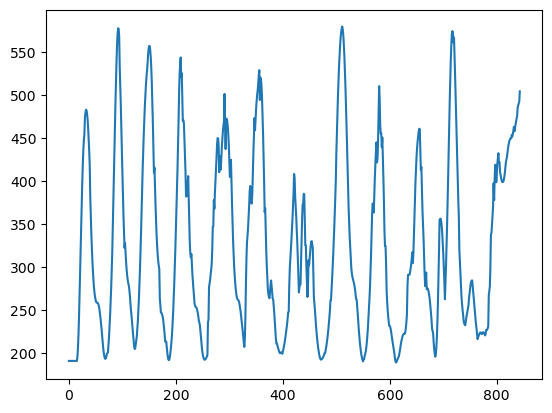

In [47]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [48]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

In [49]:
df_ball_positions['ball_hit']=0

In [50]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

C:\Users\Vasu\AppData\Local\Temp\ipykernel_21056\3752280353.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1


In [51]:
len(frame_nums_with_ball_hits)


28

In [52]:
for i in range(0,len(frame_nums_with_ball_hits)):
    frame_nums_with_ball_hits[i] = 30 + frame_nums_with_ball_hits[i]
frame_nums_with_ball_hits    

[62,
 122,
 153,
 180,
 190,
 241,
 244,
 250,
 253,
 259,
 284,
 321,
 325,
 333,
 358,
 386,
 388,
 502,
 541,
 580,
 582,
 610,
 614,
 616,
 642,
 658,
 685,
 841]

In [53]:
df_ball_hit_surface = df_ball_positions.loc[frame_nums_with_ball_hits]
df_ball_hit_surface['mid_x'] = (df_ball_hit_surface['x1'] + df_ball_hit_surface['x2'])/2
df_ball_hit_surface.drop(columns=['mid_y_rolling_mean','delta_y','ball_hit'])

,x1,y1,x2,y2,mid_y,mid_x
62,545.010986,182.963821,559.465088,196.510239,189.737030,552.238037
122,741.918823,200.890411,756.223755,215.812042,208.351227,749.071289
153,778.460795,443.237722,791.333191,455.421509,449.329615,784.896993
180,452.920654,180.691208,465.225220,193.794754,187.242981,459.072937
190,474.992879,230.816462,488.629476,244.263351,237.539907,481.811178
241,453.822398,219.660197,467.660512,233.114146,226.387171,460.741455
244,446.940857,190.361664,463.849792,206.724213,198.542938,455.395325
250,503.212565,186.449801,514.978973,198.155357,192.302579,509.095769
253,471.893555,187.589005,484.523315,200.313614,193.951309,478.208435
259,419.096863,203.206238,432.913696,216.498962,209.852600,426.005280


In [54]:
ball_positions_on_surface = list(zip(df_ball_hit_surface['mid_x'], df_ball_hit_surface['mid_y']))

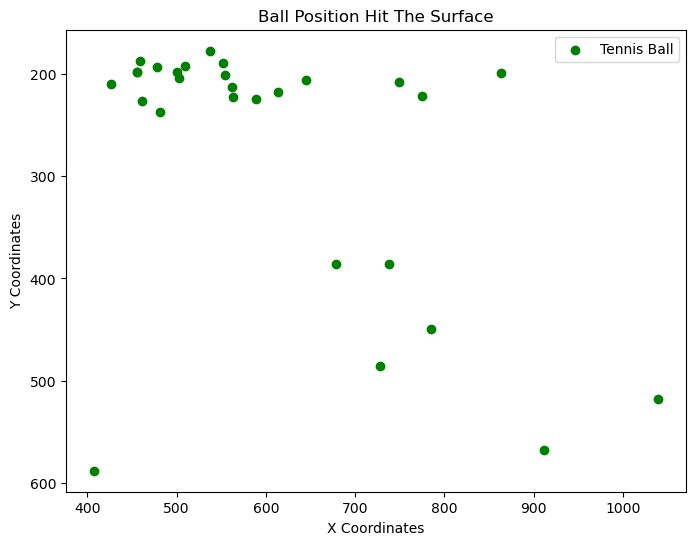

In [55]:
# Extract x and y coordinates from the list of tuples for ball
x_coords_ball = [coord[0] for coord in ball_positions_on_surface]
y_coords_ball = [coord[1] for coord in ball_positions_on_surface]


# Create a scatter plot with both sets of coordinates
plt.figure(figsize=(8, 6))

plt.scatter(x_coords_ball, y_coords_ball, c='g', alpha=1, label='Tennis Ball')


# Set the title and labels
plt.title('Ball Position Hit The Surface')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')

# Add a legend
plt.legend()


# Flip the image by inverting the x and y axis

plt.gca().invert_yaxis()

# Show the plot
plt.show()


In [56]:
class TennisCourt():
    def __init__(self, court_keypoints=None, connections=None, padding=50):
        self.court_keypoints = court_keypoints
        self.connections = connections
        self.padding = padding

    def draw_court(self, ax):
        # Plot court keypoints
        for i in range(0, len(self.court_keypoints), 2):
            ax.plot(self.court_keypoints[i], self.court_keypoints[i+1], 'ro')

        # Plot connections
        for connection in self.connections:
            start_point = connection[0] * 2
            end_point = connection[1] * 2
            ax.plot([self.court_keypoints[start_point], self.court_keypoints[end_point]], 
                    [self.court_keypoints[start_point+1], self.court_keypoints[end_point+1]], 
                    'k-', linewidth=2)
        
        ax.set_aspect('equal')

        # Set limits of x and y axes with padding
        ax.set_xlim(min(self.court_keypoints[::2]) - self.padding, max(self.court_keypoints[::2]) + self.padding)
        ax.set_ylim(min(self.court_keypoints[1::2]) - self.padding, max(self.court_keypoints[1::2]) + self.padding)

        # Draw the net
        net_start_point = (min(self.court_keypoints[::2]), int((min(self.court_keypoints[1::2]) + max(self.court_keypoints[1::2])) / 2))
        net_end_point = (max(self.court_keypoints[::2]), int((min(self.court_keypoints[1::2]) + max(self.court_keypoints[1::2])) / 2))
        ax.plot([net_start_point[0], net_end_point[0]], [.89*net_start_point[1], .89*net_start_point[1]], 'b-', linewidth=2)

        # Invert y-axis to flip the image upside down
        ax.invert_yaxis()

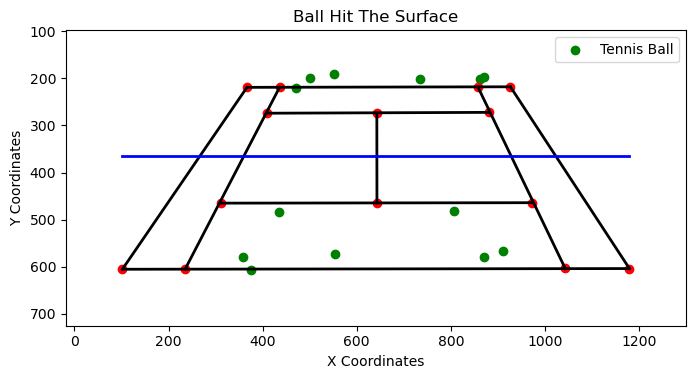

In [84]:
connections = [
    (0, 2), (4, 5), (6, 7), (1, 3),
    (0, 1), (8, 9), (10, 11), (12, 13), (2, 3)
]

# Create a TennisCourt instance with court keypoints, connections, and padding
tennis_court = TennisCourt(court_keypoints=court_keypoints, connections=connections, padding=120)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Draw the tennis court
tennis_court.draw_court(ax)

# Extract x and y coordinates from the list of tuples for ball
x_coords_ball = [coord[0] for coord in ball_positions_on_surface]
y_coords_ball = [coord[1] for coord in ball_positions_on_surface]


ax.scatter(x_coords_ball, y_coords_ball, c='g', alpha=1, label='Tennis Ball')


# Set the title and labels
ax.set_title('Ball Hit The Surface')
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')

# Add a legend
ax.legend()

# Show the plot
plt.show()

